# Compute Sensitivity Kernels and Gradients as an Example
Using the true data and a prior model, this routine computes the Gradients of the Misfit and displays them for demonstrative purposes.\
The true data loaded here should be synthetic data generated by using a specific source-receiver pair.

**Specific Example of uploaded Data**: We only consider the first and one secondary arrival for a wave travelling inside the static temperature anomaly.

In [1]:
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 11

In [2]:
# Import specific packages
import h5py
import sys
from matplotlib import gridspec
import os # for file administration
import time

# Add the folder containing .py files to the Python path
sys.path.append(
    '../Scripts')

# Import Custom Modules
import WaveProp_on_cuda
import InverseUtils
import AnimateGradients
import Plotting

### Material Equation

In [3]:
CR = "IdealGas"

# Import relevant CR:
sys.path.append(
    '../ConstitutiveRelationships')

if CR == 'IdealGas':
    from CR_IdealGas import c2
    from CR_IdealGas import c_inv
    # typical soundspeed
    c0 = 346     # [m/s]       
else:
    print('wrong constituive relationship')

### Import True Waveform Data 
Read the data produced from the foward simulation

In [4]:
# Choose folder
Model = "BuoyancyFree"
Array = "4x4"

folder = f'../../Data/Full-Waveform Data and Reconstructions/{Model} {Array}'

In [5]:
# Choose source and receiver
s = [2]
r = [7]

# load true data and compute misfit
h5_data = folder+f"/Data_src-{s}_rec-{r}_mediumSTF.h5"
print('True Data:', h5_data)

with h5py.File(h5_data,"r") as h:
    # import true waveforms
    #----------------------
    seism0 = h["seism"][:,:].copy()
    dt = h["dt"][()]
    
    #import true model
    DeltaT = h["DeltaT"][:,:].copy()
    vx = h["vx"][:,:].copy()
    vy = h["vy"][:,:].copy()
    dh = h["dh"][()]
    ijsrc = h["srcij"][:,:].copy()
    ijrec = h["recij"][:,:].copy()

m = np.zeros((3,DeltaT.shape[0],DeltaT.shape[1]))

m[0,:,:] = DeltaT
m[1,:,:] = vx
m[2,:,:] = vy

True Data: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Data_src-[2]_rec-[7]_mediumSTF.h5


### Input Scaling and Sourcetimefunction
For now, read from synthetic data as well

In [6]:
# Read from a Simulation
print('True Data:', h5_data)
with h5py.File(h5_data,"r") as h:

    # import true waveforms
    #----------------------
    Ma = h["Ma"][()]
    T0 = h["T0"][()]
    DeltaT0 = h["DeltaT0"][()]
    # and STF
    sourcetf = h["sourcetf"][:,:].copy()

N_sensors, nt = sourcetf.shape

t = np.arange(nt)*dt

# Domain Size
L = 0.25
# sound wavelength
lam = L/50

True Data: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Data_src-[2]_rec-[7]_mediumSTF.h5


### Define Prior Model and Simulation Parameters
For now, read geometry from true model

In [7]:
# define model geometry - we read this from the synthetic true model for now.
nx, ny = DeltaT.shape

# zero prior model
m_prior = np.zeros((3,nx,ny))

# rescale plotting grid
x = np.arange(0,nx)*dh
y = np.arange(0,ny)*dh

srcpos = ijsrc.T*dh
recpos = ijrec.T*dh


# Initialize input parameter dictionary for prior simulations
inpar = {}
inpar["ntimesteps"] = nt
inpar["nx"] = nx
inpar["ny"] = ny
inpar["dt"] = dt
inpar["dh"] = dh
inpar["T0"] = T0            
inpar["DeltaT0"] = DeltaT0 
inpar["Ma"] = Ma
inpar["savesnapshot"] = False
inpar["snapevery"] = 1000
inpar["savefinal"] = True
inpar["comp_fact"] = 4 # compression factor for saved wavefields (insert divider of both nx and ny)
inpar["boundcond"] = "ReflBou"
inpar["constrel"] = CR

## Run Prior Simulation or load Prior Waveform Data

In [8]:
priorfile_ab = f"{folder}/Data_m0_src-{s}_rec-{r}.h5"

# Generate Prior Waveforms?
Run_Prior_Simulation = False
#********************************************

if Run_Prior_Simulation:
    seism, p_save, p_final = WaveProp_on_cuda.solveacoustic2D(inpar, ijsrc, m_prior, sourcetf, ijrec,
                                                              saveh5 = True, outfileh5 = priorfile_ab)
    
else:
    print('Prior Model Data from:', priorfile_ab)
    h=h5py.File(priorfile_ab,"r")

    #----------------------------
    seism = h["seism"][:,:].copy()
    p_final = h["p_final"][:,:,:].copy()
    h.close()

Prior Model Data from: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Data_m0_src-[2]_rec-[7].h5


## Compute and Display Adjoint Source
From the true and prior waveforms the adjoint source can be generated and displayed. \
Here, one can get an idea of the **magnitude of the phase shift** if zooming in.

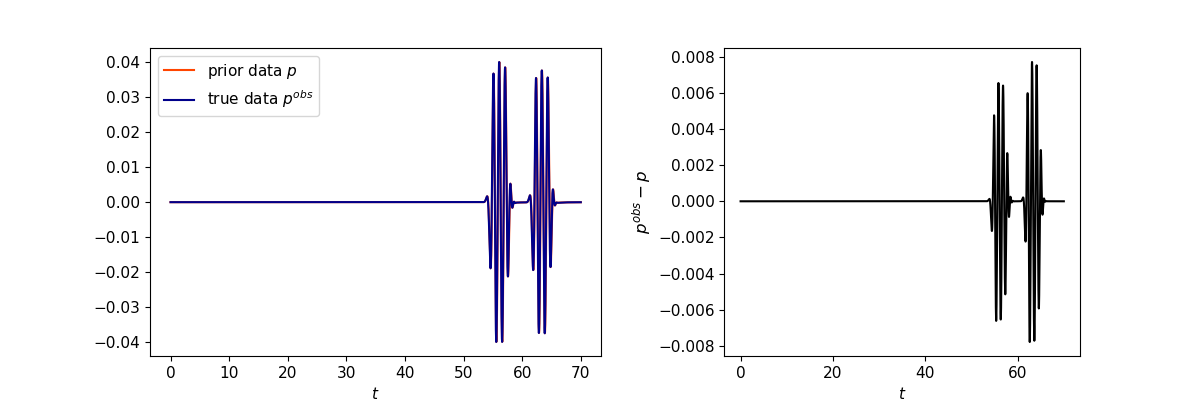

In [9]:
adj_src = InverseUtils.adjointsource_L2(seism0, seism)

%matplotlib widget

f = plt.figure(figsize = (12,4))
gs = gridspec.GridSpec(1, 10)

gs.update(wspace = 0.4, hspace = 0.3)

ax1 = plt.subplot(gs[0, 0:5])  # first column
ax2 = plt.subplot(gs[0, 6:10])  # second column, first row

ax1.plot(t, seism[0,:], color = "orangered", label = "prior data $p$")
ax1.plot(t, seism0[0,:], color = "darkblue", label = "true data $p^{obs}$")
#ax1.set_xlim(63,63.5)
ax1.set_xlabel("$t$")
ax1.legend(fontsize = 11)

ax2.plot(t, adj_src[0,:], color = "k")
#ax2.set_xlim(55,68)
ax2.set_xlabel("$t$")
ax2.set_ylabel("$p^{obs} - p$", fontsize = 12)
plt.show()

In [10]:
plt.close(f) # close the interactive plot befor moving on

## Compute, Filter and Animate the Gradient
Including animation on how the sensitivity kernel is formed.

In [11]:
%matplotlib inline

gradfile_ab = f"{folder}/Gradient_src-{s}_rec-{r}.h5"

# Compute Gradient here?
Run_Inverse_Simulation = False

if Run_Inverse_Simulation:
    inpar["savesnapshot"] = True
    inpar["snapevery"] = 200
    grad_ab = InverseUtils.computegrad2D(inpar, ijrec, m_prior, adj_src,
                                         p_final, saveh5=True, outfileh5 = gradfile_ab)
else:
    # load file with pressure and adjoint field
    h=h5py.File(gradfile_ab,"r")
    grad_ab = np.zeros((3,nx,ny))
    grad_ab[0,:,:] = h["gradient_c"]
    grad_ab[1,:,:] = h["gradient_vx"]
    grad_ab[2,:,:] = h["gradient_vy"]
    h.close()

Display the Gradient (without smoothing)

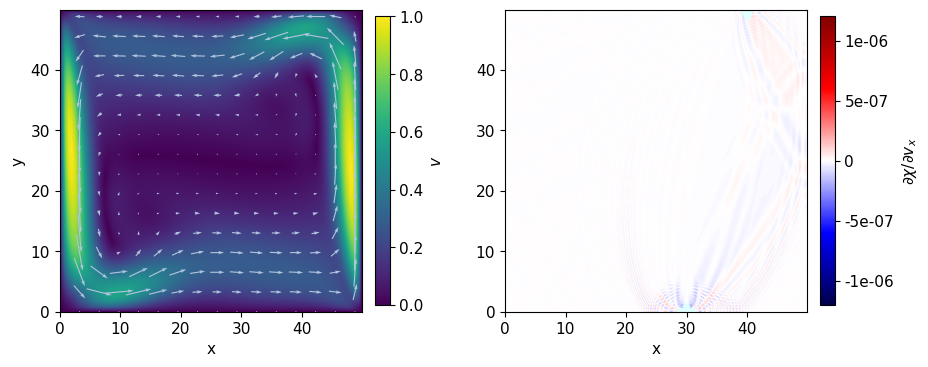

In [12]:
# Gradient w.r.t. which model parameter  (derivative of misfit towards which model parameter)?
# 0 = c, 1 = vx, 2 = vy
m_index = 1

Plotting.ModelvGradient(x,y,m,grad_ab,m_index,srcpos=srcpos, recpos=recpos, comp_fact = 1, v_inc = 100)

We see many small scale features and a large range of magnitudes in the Gradient. We now smooth the Gradient first and then Display it:

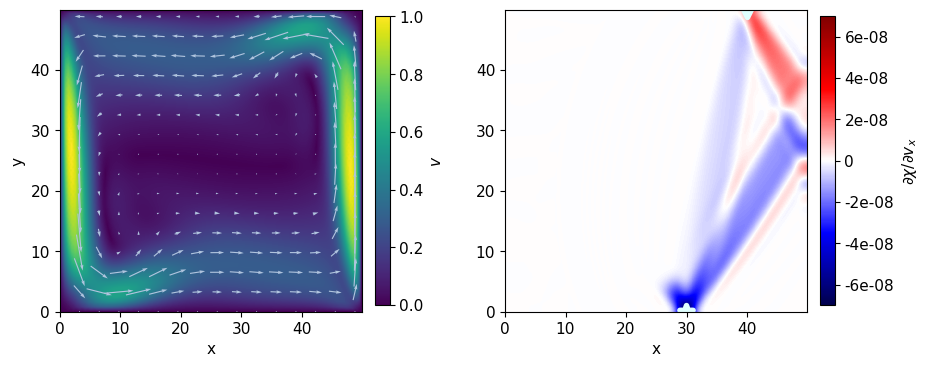

In [13]:
# Apply Gaussian Smoothing kernel with standard deviation 'sigmaT/V' [wavelengths]
# For DeltaT
sigmaT = 1
# For v
sigmaV = 1

grad_ab_smooth = np.zeros(grad_ab.shape)

# Smooth first gradients
grad_ab_smooth[0,:,:] = InverseUtils.filter_SepGaussian(grad_ab[0,:,:], dh, lambda_min = sigmaT)
grad_ab_smooth[1,:,:] = InverseUtils.filter_SepGaussian(grad_ab[1,:,:], dh, lambda_min = sigmaV)
grad_ab_smooth[2,:,:] = InverseUtils.filter_SepGaussian(grad_ab[2,:,:], dh, lambda_min = sigmaV)

Plotting.ModelvGradient(x,y,m,grad_ab_smooth,m_index,srcpos=srcpos, recpos=recpos,comp_fact = 1, v_inc = 100)

Note that a positive value of the gradient suggests a negative update in the model and vice versa (gradient descent). This should be in accordance with going from a zero prior to the true model on the right.

## We can generate movies of how the sensitivity kernels are formed:
Here, the faint grey ripples are the back-propageted forward wavfield and the red-black ripples are the back-propagated adjoint wavefield. Where the product between the two is non-zero, one forms the sensitivity kernel.

In [18]:
# which component of gradient to display:
m_index = 1 # 0=c, 1=v_x, 2=v_y
#*********

Anim_folder = "../../Animations"
if not os.path.exists(Anim_folder):
    os.makedirs(Anim_folder)
    print(f"Folder '{Anim_folder}' created.")


anim = AnimateGradients.animategradients(gradfile_ab, m_index, fps = 20,
                                         clipamplitude=0.4, outfile = f"{Anim_folder}/{Model} {Array}_animGrad_vx_src-{s}_rec-{r}.mp4")
plt.close(anim._fig)

Folder '../../Animations' created.


In [19]:
# show in notebook
from IPython.display import HTML
HTML(anim.to_html5_video())

... and a selcted snapshot thereof:

## Compute the Gradient for the reciprocal shot.
For this, quickly load the true data, compute the prior waveforms and get the adjoint source.

In [14]:
# Load true data and source-receiver positions
h5_data = f"{folder}/Data_src-{r}_rec-{s}_mediumSTF.h5"
print('True Data:', h5_data)
with h5py.File(h5_data,"r") as h:
    # import true waveforms
    seism0 = h["seism"][:,:].copy()
    dt = h["dt"][()]
    #import source-receiver info
    ijsrc = h["srcij"][:,:].copy()
    ijrec = h["recij"][:,:].copy()
    sourcetf = h["sourcetf"][:,:].copy()

# we do not want to save any snapshots here...
inpar["savesnapshot"] = False


priorfile_ba = f"{folder}/Data_m0_src-{r}_rec-{s}.h5"

# Generate Prior Waveforms?--------------------------------------
Run_Prior_Simulation = False

if Run_Prior_Simulation:
    seism, p_save, p_final = WaveProp_on_cuda.solveacoustic2D(inpar, ijsrc, m_prior, sourcetf, ijrec,
                                                              saveh5 = True, outfileh5 = priorfile_ba)
else:
    # read prior waveforms
    print('Prior Model Data from:', priorfile_ba)
    with h5py.File(priorfile_ba,"r") as h:
        #----------------------------
        seism = h["seism"][:,:].copy()
        p_final = h["p_final"][:,:,:].copy()
#----------------------------------------------------------------

# compute Adjoint Source
adj_src = InverseUtils.adjointsource_L2(seism0, seism)

gradfile_ba = f"{folder}/Gradient_src-{r}_rec-{s}.h5"

# Compute Gradient now?------------------------------------------
Run_Inverse_Simulation = False

if Run_Inverse_Simulation:
    grad_ba = InverseUtils.computegrad2D(inpar, ijrec, m_prior, adj_src,
                                         p_final, saveh5=True, outfileh5 = gradfile_ba)
else:
    # load gradients
    print('Gradients from:', gradfile_ba)
    with h5py.File(gradfile_ba,"r") as h:
        grad_ba = np.zeros((3,nx,ny))
        grad_ba[0,:,:] = h["gradient_c"]
        grad_ba[1,:,:] = h["gradient_vx"]
        grad_ba[2,:,:] = h["gradient_vy"]
#---------------------------------------------------------------

True Data: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Data_src-[7]_rec-[2]_mediumSTF.h5
Prior Model Data from: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Data_m0_src-[7]_rec-[2].h5
Gradients from: ../../Data/Full-Waveform Data and Reconstructions/BuoyancyFree 4x4/Gradient_src-[7]_rec-[2].h5


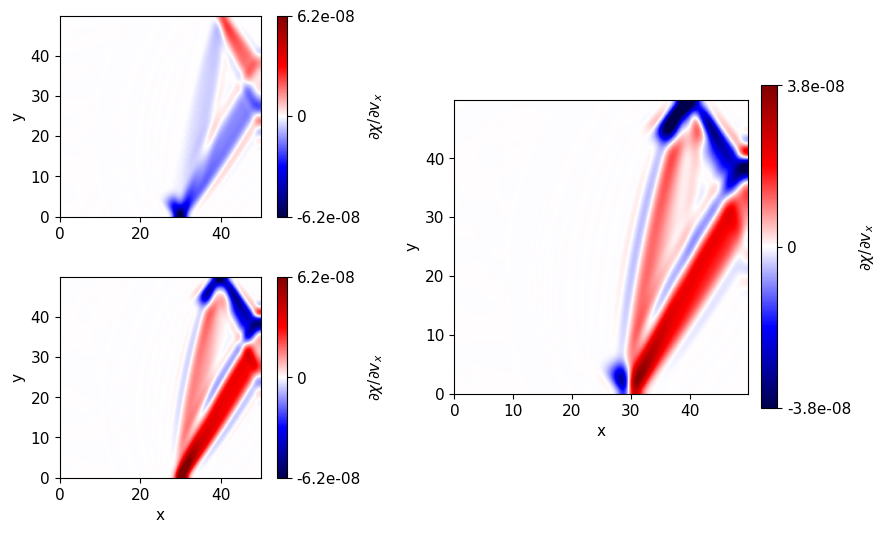

In [16]:
grad_ba_smooth = np.zeros(grad_ab.shape)

# Smooth first gradients
grad_ba_smooth[0,:,:] = InverseUtils.filter_SepGaussian(grad_ba[0,:,:], dh, lambda_min = sigmaT)
grad_ba_smooth[1,:,:] = InverseUtils.filter_SepGaussian(grad_ba[1,:,:], dh, lambda_min = sigmaV)
grad_ba_smooth[2,:,:] = InverseUtils.filter_SepGaussian(grad_ba[2,:,:], dh, lambda_min = sigmaV)


#Sum of Gradients
grad_smooth = grad_ab + grad_ba

# Smooth gradients
grad_smooth[0,:,:] = InverseUtils.filter_SepGaussian(grad_smooth[0,:,:], dh, lambda_min = sigmaT)
grad_smooth[1,:,:] = InverseUtils.filter_SepGaussian(grad_smooth[1,:,:], dh, lambda_min = sigmaV)
grad_smooth[2,:,:] = InverseUtils.filter_SepGaussian(grad_smooth[2,:,:], dh, lambda_min = sigmaV)

# component of gradient:
m_index = 1 # 0=c, 1=v_x, 2=v_y

# display gradient:
Plotting.PlotReciprocal_Grad(x,y,grad_ab_smooth,grad_ba_smooth,grad_smooth,m_index)

## Load and Display Gradient generated by FWI-Routine:
Here we display a full gradient (that is, when all sources and receivers are active and sensitivity maps are formed between them) as created by the FWI-Notebook.\
It is most instructive to show the gradient before the first iterateion ($k = 0$) since it shows how to update the zero prior model.

In [17]:
folder = '../../Data/Full-Waveform Data and Reconstructions/Wiens 4x4'

In [18]:
# For DeltaT
sigma0 = 1

gradfile = f"{folder}/Gradient_m0_SimAqu.h5"
# load file with gradient
with h5py.File(gradfile, "r") as h:
    nx, ny = h["gradient_c"].shape
    grad = np.zeros((3,nx,ny))
    grad[0,:,:] = h["gradient_c"]
    grad[1,:,:] = h["gradient_vx"]
    grad[2,:,:] = h["gradient_vy"]
    dh = h["dh"][()]

grad_smooth = np.zeros(grad.shape)
grad_smooth[0,:,:] = InverseUtils.filter_SepGaussian(grad[0,:,:], dh, lambda_min = sigma0)
grad_smooth[1,:,:] = InverseUtils.filter_SepGaussian(grad[1,:,:], dh, lambda_min = sigma0)
grad_smooth[2,:,:] = InverseUtils.filter_SepGaussian(grad[2,:,:], dh, lambda_min = sigma0)

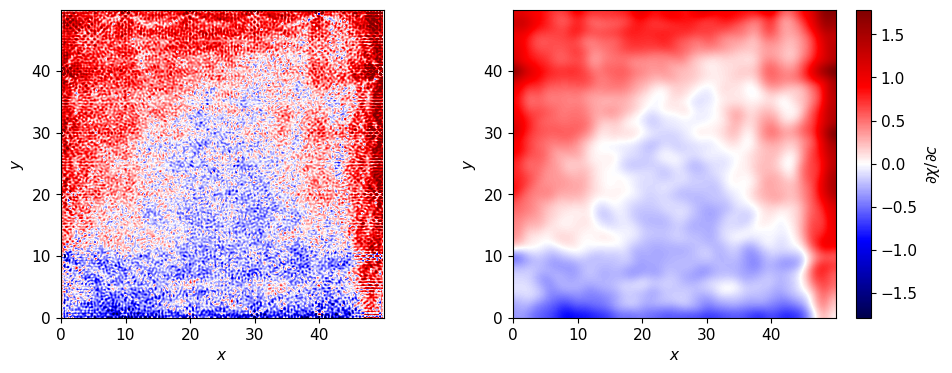

In [19]:
# component of gradient:
m_index = 0 # 0=c, 1=v_x, 2=v_y
components = ["c", "v_x", "v_y"]

x = np.arange(nx)*dh
y = np.arange(ny)*dh

f = plt.figure(figsize = (10,4))
gs = gridspec.GridSpec(1, 2)

gs.update(wspace = 0.4, hspace = 0.3)

ax1 = plt.subplot(gs[0, 0])  # first column
ax2 = plt.subplot(gs[0, 1])  # second column, first row

clim = [-np.max(np.abs(grad_smooth[m_index,:,:])), np.max(np.abs(grad_smooth[m_index,:,:]))]
im1 = ax1.pcolormesh(x,y, grad[m_index,:,:].T, cmap = "seismic", clim = clim)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")

im2 = ax2.pcolormesh(x,y, grad_smooth[m_index,:,:].T, cmap = "seismic", clim = clim)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")

cax = f.add_axes([ax2.get_position().x1 + 0.02, ax1.get_position().y0, 0.015, ax1.get_position().height])
f.colorbar(im1, cax=cax, label = f"$\\partial \\chi / \\partial {components[m_index]}$")
plt.show()

Clearly, for the model of Wiens, the negative values of the gradient are located at the positive temperature anomaly. If we descent along this gradient the next model $m_1$ will be closer to the true temperature field.